# LLaMA3-8B Benchmarking:

1. **Model loading**

    1. Dependent variables: model loading rate, model loading time
    2. Independent variables: source drive, device map, CPU cores

2. **Inference**

    1. Dependent variables: inference rate, inference time
    2. Independent variables: model, device map, quantization, decoding strategy, CPU cores, max new tokens 

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import configuration as config
import functions.plotting as plot_funcs

# Datasets to load
datasets={
    'loading': 'model_loading_benchmark.jsonl',
    'inference': 'generation_benchmark.jsonl',
    'decoding': 'decoding_strategy_benchmark.jsonl'
}

# Translation dict for column names
column_renaming_dict={
    'load_time': 'Load time (sec.)',
    'device_map': 'Device map',
    'cache_dir': 'Cache location',
    'cpu_cores': 'CPU cores',
    'quantization': 'Quantization',
    'decoding_strategy': 'Decoding strategy',
    'max_new_tokens': 'Max new tokens',
    'tokens_generated': 'Tokens generated',
    'inference_time': 'Inference time (sec.)',
    'generation_rate': 'Generation rate (tokens per sec.)',
    'hf_model_string': 'Model',
    'output_length_tokens': 'Output length (tokens)',
    'peak_memory': 'Peak memory (GB)',
    'iteration': 'Iteration'
}

# Translation dict for string values
value_renaming_dict={
    '/mnt/ramdisk/huggingface_transformers_cache': 'Ramdisk',
    '/mnt/fast_scratch/huggingface_transformers_cache': 'NVMe SSD',
    '/mnt/arkk/huggingface_transformers_cache': 'NFS RAID5',
    '/home/siderealyear/huggingface_transformers_cache': 'SATA SSD',
    'meta-llama/Meta-Llama-3-8B': 'LLaMA3-8B',
    'meta-llama/Llama-2-7b-hf': 'LLaMA2-7B',
    'tiiuae/falcon-7b': 'Falcon-7B',
    'mistralai/Mistral-7B-v0.3': 'Mistral-7B',
    'cuda:0': 'GTX1070',
    'cuda:1': 'Tesla K80',
    'sequential': 'Multi-GPU, sequential',
    'auto': 'Mixed GPU/CPU',
    'cpu': 'CPU only'   
}

# Load and prepare datasets
datasets=plot_funcs.load_datasets(
    datasets=datasets,
    column_renaming_dict=column_renaming_dict,
    value_renaming_dict=value_renaming_dict,
    data_path=config.BENCHMARKING_DATA_PATH
)

# Remove an outlier above 2 minutes from one iteration of the NFS RAID5 trial
# probably some kind of network hiccup and not really representative of the true speed.
datasets['loading']=datasets['loading'][datasets['loading']['Load time (sec.)'] < 120]

# Add a feature for model loading rate with units of per second so that 
# 'higher is better' consistent with rate plots below
datasets['loading']['Load rate (Hz)']=1 / datasets['loading']['Load time (sec.)']

/mnt/arkk/llm_detector_benchmarking/benchmarking


## 1. Model loading

### 1.1. TLDR

1. **Winner:** Low 7 seconds is the fastest we can load onto a GPU: 16 CPU cores, multi-GPU sequential, NFS RAID5. 
2. **Factor importance:** CPU cores (tens of seconds) > device (a few seconds) > source drive (tenths or hundredths of seconds).
3. **Recommendation:** Use whatever device & cache location makes the most sense for the application, give torch 8 CPU cores during model loading.

### 1.2. LLaMA3 loading rate

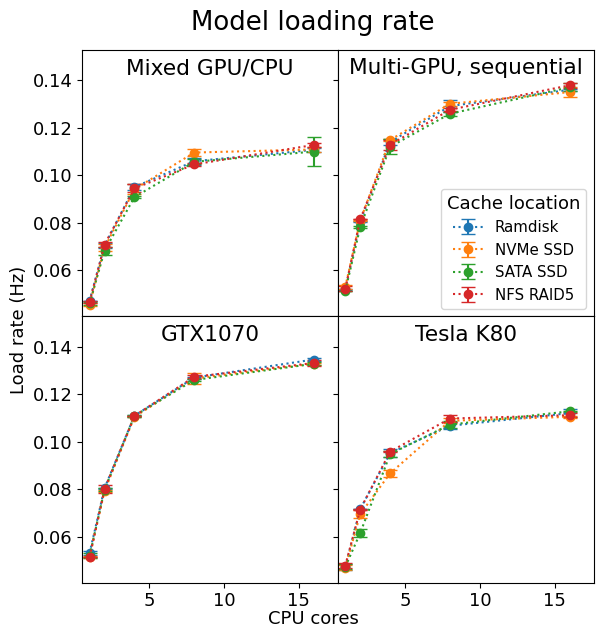

In [2]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title = 'Model loading rate',
    data = datasets['loading'],
    exclusions = {
        'Device map': ['CPU only'], 
        'Model': ['LLaMA2-7B','Falcon-7B','Mistral-7B']
    },
    panel_factor = 'Device map',
    series_factor = 'Cache location',
    independent_var = 'CPU cores',
    dependent_var = 'Load rate (Hz)',
    legend_loc = 'lower right'
).show()

### 1.3. LLaMA3 loading time averages: 16 CPU cores

In [3]:
max_cpu_cores_df=datasets['loading'][(datasets['loading']['CPU cores'] == 16) & (datasets['loading']['Model'] == 'LLaMA3-8B')]

max_cpu_cores_df.groupby(                
    ['Cache location','Device map','CPU cores'],
    as_index=False
)['Load time (sec.)'].mean()

,Cache location,Device map,CPU cores,Load time (sec.)
0,NFS RAID5,CPU only,16,3.067285
1,NFS RAID5,GTX1070,16,7.510517
2,NFS RAID5,Mixed GPU/CPU,16,8.870255
3,NFS RAID5,"Multi-GPU, sequential",16,7.256855
4,NFS RAID5,Tesla K80,16,8.993494
5,NVMe SSD,CPU only,16,2.803855
6,NVMe SSD,GTX1070,16,7.524143
7,NVMe SSD,Mixed GPU/CPU,16,9.023621
8,NVMe SSD,"Multi-GPU, sequential",16,7.411310
9,NVMe SSD,Tesla K80,16,9.046314


### 1.4. Observations

1. The model cache location does not make much of a difference, my guess it that the linux kernel is pretty smart about caching to RAM. We could try and do some kind of 'naive' benchmark - where we don't load the same model multiple times in a row. Or maybe there is some way to remove it from the RAM cache. Probably not worth the time. Lots of effort for very little gain. 
2. Loading the model into a multi-GPU sequential device map is fastest overall, but is within about a tenth of a second of the GTX1070. The GTX1070 beats the K80 by 0.5 - 1.5 seconds. Note: in reality, loading the model onto CPU only is ~2-3x faster, but inference on CPU is so slow to make the fast loading time pretty much irrelevant. Unless, maybe if we are optimizing something that necessitates loading the model over and over for a quick task.
2. CPU core count makes the biggest difference of all the factors tested. After ~8 cores, there is not much benefit to adding more.

### 1.5. Conclusions

1. The fastest possible model loading rate is achieved using 16 CPU cores to load onto the CPU from the NVMe SSD.
2. If the CPU only device map is excluded due to low inference rate, then the GTX1070 wins.
3. Use 4-8 CPU cores when loading the model if possible. 
4. It doesn't really matter where the model is loaded from, but it's best to load it from a dedicated drive, if possible.

## 2. Inference

### 2.1. TLDR

1. **Winner**: Load the 4-bit quantized model from an SSD onto the GTX1070 using 4-8 CPU cores. Run model default decoding strategy.
2. **Factor importance rank**: Device (tens of seconds) ~= decoding strategy (tens of seconds) > output length (seconds) > CPU cores (hundredths of a second).

### 2.2. LLaMA3 generation rate: 4-bit vs 8-bit quantization, 4 CPU cores

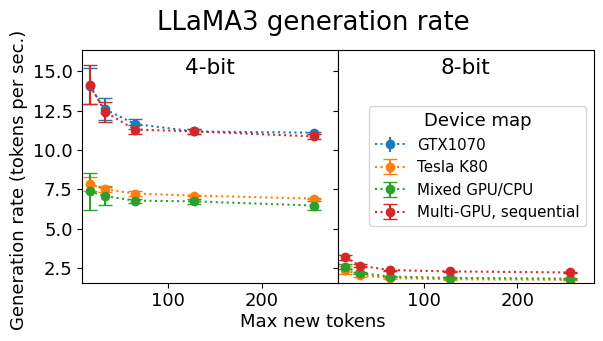

In [4]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title = 'LLaMA3 generation rate',
    data = datasets['inference'][datasets['inference']['CPU cores'] == 4],
    plot_rows = 1,
    plot_cols = 2,
    exclusions = {
        'Device map': ['CPU only'],
        'Model': ['LLaMA2-7B','Falcon-7B','Mistral-7B']
    },
    panel_factor = 'Quantization',
    series_factor = 'Device map',
    independent_var = 'Max new tokens',
    dependent_var = 'Generation rate (tokens per sec.)',
    legend_loc = 'center right'
).show()

### 2.3. LLaMA3 inference time averages: 256 tokens, 4-bit vs 8-bit quantization, 4 CPU cores

In [5]:
max_cpu_cores_df=datasets['inference'][(datasets['inference']['CPU cores'] == 4) & (datasets['inference']['Max new tokens'] == 256) & (datasets['inference']['Device map'] != 'CPU only')]

max_cpu_cores_df.groupby(                
    ['Device map', 'Quantization'],
    as_index=False
)['Inference time (sec.)'].mean()

,Device map,Quantization,Inference time (sec.)
0,GTX1070,4-bit,23.763572
1,GTX1070,8-bit,93.049241
2,Mixed GPU/CPU,4-bit,44.739152
3,Mixed GPU/CPU,8-bit,137.845025
4,"Multi-GPU, sequential",4-bit,25.084211
5,"Multi-GPU, sequential",8-bit,95.533247
6,Tesla K80,4-bit,40.577506
7,Tesla K80,8-bit,149.389037


### 2.4. LLaMA3 generation rate: 4-bit quantization

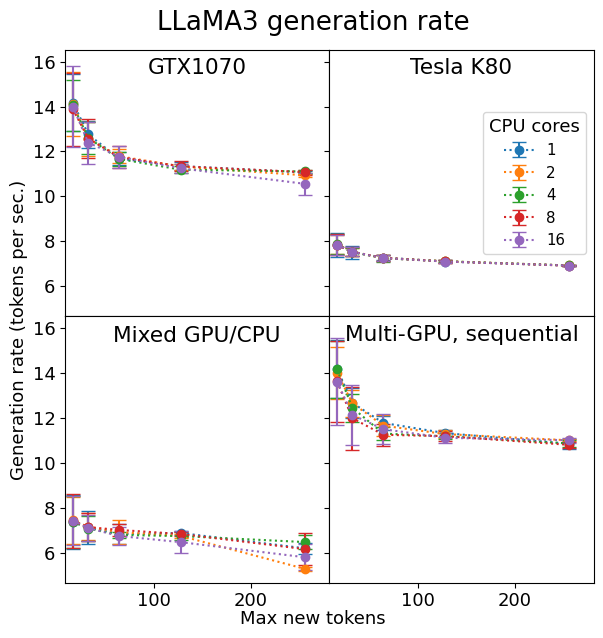

In [6]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title = 'LLaMA3 generation rate',
    data = datasets['inference'],
    exclusions = {
        'Quantization': ['8-bit'], 
        'Device map': ['CPU only'],
        'Model': ['LLaMA2-7B','Falcon-7B','Mistral-7B']
    },
    panel_factor = 'Device map',
    series_factor = 'CPU cores',
    independent_var = 'Max new tokens',
    dependent_var = 'Generation rate (tokens per sec.)',
    legend_loc = 'center right'
).show()

### 2.5. LLaMA3 inference time averages: 4-bit quantization, 256 tokens & 4 CPU cores

In [7]:
max_cpu_cores_df=datasets['inference'][(datasets['inference']['CPU cores'] == 4) & (datasets['inference']['Quantization'] == '4-bit') & (datasets['inference']['Max new tokens'] == 256) & (datasets['inference']['Device map'] != 'CPU only')]

max_cpu_cores_df.groupby(                
    ['Device map'],
    as_index=False
)['Inference time (sec.)'].mean()

,Device map,Inference time (sec.)
0,GTX1070,23.763572
1,Mixed GPU/CPU,44.739152
2,"Multi-GPU, sequential",25.084211
3,Tesla K80,40.577506


### 2.6. Observations

1. Inference is about 2-3x faster when the model is loaded in 4-bit vs 8-bit.
2. The GTX1070 is about twice as fast as the K80.
3. Interestingly, mixed GPU/CPU appears limited by the K80's generation rate, while multi-GPU sequential appears limited by the GTX1070's rate.
4. The number of CPU cores available has little to no effect on runs which use a GPU.
5. The larger *max_new_tokens*, the slower the generation rate. For GPU only runs, most of the decrease in rate happens up to about 64 tokens. The mixed GPU/CPU runs continue to decrease in rate linearly out to 256 tokens.

### 2.7. LLaMA3 generation rate: CPU only

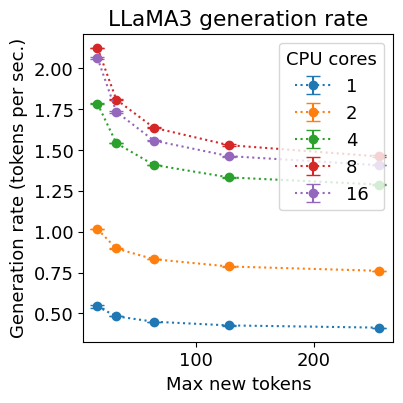

In [8]:
plot_funcs.single_errorbar(
    figure_title='LLaMA3 generation rate',
    data=datasets['inference'][datasets['inference']['Device map'] == 'CPU only'],
    exclusions = {
        'Quantization': ['8-bit'], 
        'Model': ['LLaMA2-7B','Falcon-7B','Mistral-7B']
    },
    series_factor='CPU cores',
    independent_var='Max new tokens',
    dependent_var='Generation rate (tokens per sec.)'
).show()

### 2.8. LLaMA3 inference time averages: CPU only, 256 tokens

In [9]:
max_cpu_cores_df=datasets['inference'][(datasets['inference']['Device map'] == 'CPU only') & (datasets['inference']['Max new tokens'] == 256)]

max_cpu_cores_df.groupby(                
    ['CPU cores'],
    as_index=False
)['Inference time (sec.)'].mean()

,CPU cores,Inference time (sec.)
0,1,590.535386
1,2,326.789191
2,4,202.093445
3,8,201.629580
4,16,215.781350


### 2.9. Observations

1. Inference on CPU is ~8x slower than 4-bit inference and ~2x slower than 8-bit inference using a GPU.
2. The CPU generation rate is highly dependent on the number of CPU cores used with rates differing as much as 3-4x depending on *max_new_tokens*
3. CPU inference generally slows down as the output length increases. For short outputs (64 tokens or less) 8 CPU cores is fastest, but for long outputs (128 tokens and up) 4 CPU cores is fastest.


### 2.10. Inference time averages: all devices, 256 tokens, 4 CPU cores

In [10]:
large_output_df=datasets['inference'][(datasets['inference']['Max new tokens'] == 256) & (datasets['inference']['CPU cores'] == 4)]

large_output_df.groupby(                
    ['Quantization','Device map'],
    as_index=False
)['Inference time (sec.)'].mean()

,Quantization,Device map,Inference time (sec.)
0,4-bit,CPU only,203.968147
1,4-bit,GTX1070,23.763572
2,4-bit,Mixed GPU/CPU,44.739152
3,4-bit,"Multi-GPU, sequential",25.084211
4,4-bit,Tesla K80,40.577506
5,8-bit,CPU only,200.218743
6,8-bit,GTX1070,93.049241
7,8-bit,Mixed GPU/CPU,137.845025
8,8-bit,"Multi-GPU, sequential",95.533247
9,8-bit,Tesla K80,149.389037


### 2.9. Conclusions
1. Fastest possible time to generate 256 tokens from a cold start is ~31 seconds: ~7.5 seconds to load the model and 24 seconds for inference.
2. Generating 256 tokens on CPU would take about 203 seconds, or about 6.5x times longer than on GPU.
2. Best overall configuration so far is to load the 4-bit quantized model from a SSD onto the GTX1070 using 4-8 CPU cores.
1. The fastest generation rate is achieved with the GTX1070 and a *max_new_tokens* size of 16.
2. Use the GTX1070 where possible for the fastest single model runs, but in situations were multiple models can be run in parallel using both of the K80's chips will give a net training rate that is competative with the GTX1070.
3. Use 4-8 CPU cores where possible.

## 3. Decoding strategy

### 3.1. LLaMA3 generate rate: K80 vs GTX1070

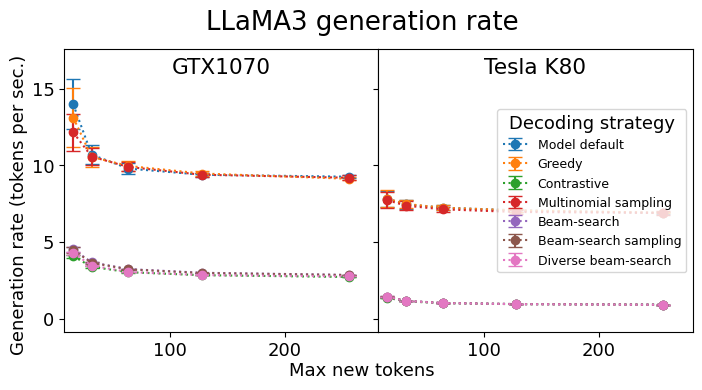

In [11]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title = 'LLaMA3 generation rate',
    data = datasets['decoding'],
    exclusions = {
        'Device map': ['CPU'],
        'Model': ['LLaMA2-7B','Falcon-7B','Mistral-7B']
    },
    y_axis_extra_pad = 1.0,
    plot_rows = 1,
    plot_cols = 2,
    plot_width = 3.5,
    plot_height = 3.5,
    panel_factor = 'Device map',
    series_factor = 'Decoding strategy',
    independent_var = 'Max new tokens',
    dependent_var = 'Generation rate (tokens per sec.)',
    legend_loc = 'center right',
    legend_font='x-small'
).show()

### 3.2. LLaMA3 inference time averages: K80 vs GTX1070, 256 tokens

In [12]:
large_output_df=datasets['decoding'][(datasets['decoding']['Max new tokens'] == 256) & (datasets['decoding']['Model'] == 'LLaMA3-8B') & (datasets['decoding']['Device map'] != 'CPU only')]

large_output_df.groupby(                
    ['Decoding strategy','Device map'],
    as_index=False
)['Inference time (sec.)'].mean()

,Decoding strategy,Device map,Inference time (sec.)
0,Beam-search,GTX1070,93.213515
1,Beam-search,Tesla K80,291.803916
2,Beam-search sampling,GTX1070,93.611507
3,Beam-search sampling,Tesla K80,292.512283
4,Contrastive,GTX1070,97.878246
5,Contrastive,Tesla K80,292.929612
6,Diverse beam-search,GTX1070,96.561830
7,Diverse beam-search,Tesla K80,294.362908
8,Greedy,GTX1070,29.173037
9,Greedy,Tesla K80,38.530665


### 3.2. Generation rate by model: GTX1070

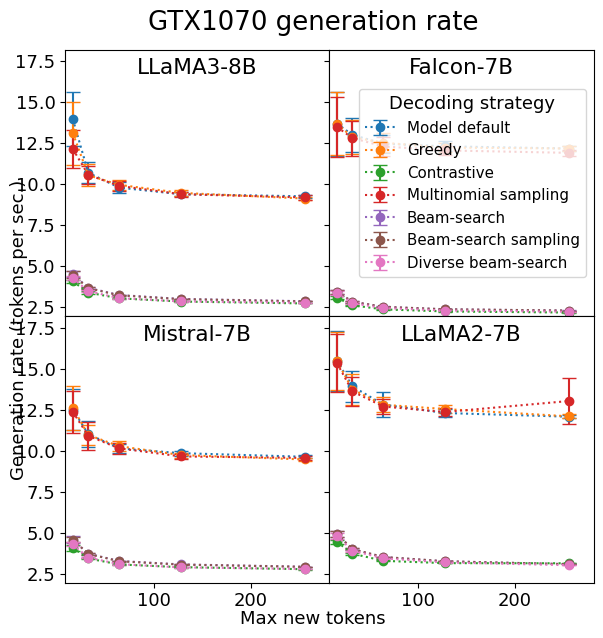

In [13]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title='GTX1070 generation rate',
    data=datasets['decoding'],
    exclusions={'Device map': ['Tesla K80', 'CPU only']},
    panel_factor='Model',
    series_factor='Decoding strategy',
    independent_var='Max new tokens',
    dependent_var='Generation rate (tokens per sec.)',
    legend_loc='center right'
).show()

### 3.4. LLaMA3 generation rate, CPU only

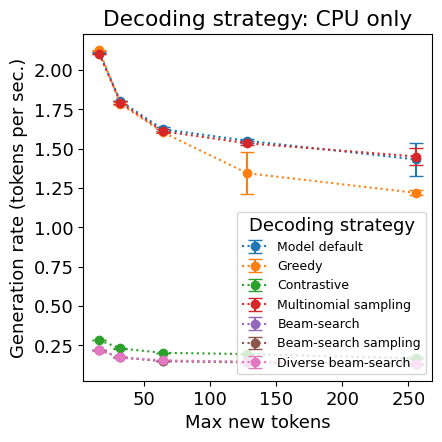

In [14]:
plot_funcs.single_errorbar(
    figure_title = 'Decoding strategy: CPU only',
    data = datasets['decoding'][datasets['decoding']['Model'] == 'LLaMA3-8B'],
    exclusions = {
        'Device map': ['GTX1070', 'Tesla K80'],
        'Model': ['LLaMA2-7B','Falcon-7B','Mistral-7B']
    },
    series_factor = 'Decoding strategy',
    independent_var = 'Max new tokens',
    dependent_var = 'Generation rate (tokens per sec.)',
    plot_width = 4.5,
    plot_height = 4.5,
    legend_loc = 'lower right',
    legend_font = 'x-small'
).show()

### 3.5. Generation rate by model, CPU only

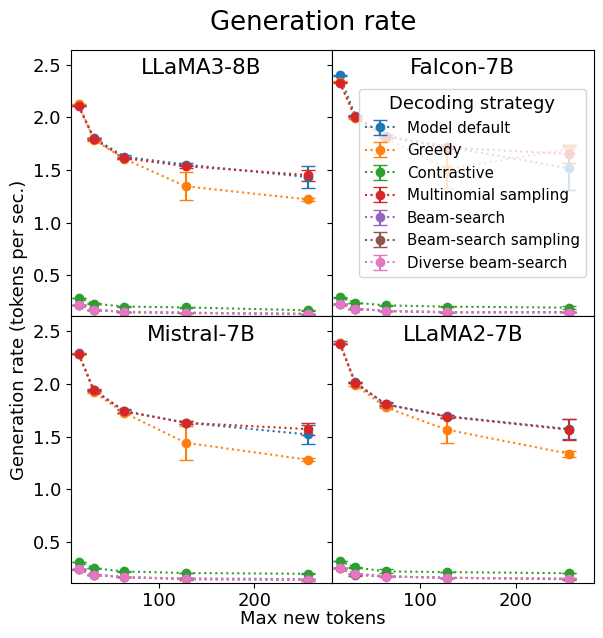

In [15]:
plot_funcs.multipanel_error_bar_two_factors(
    figure_title = 'Generation rate',
    data = datasets['decoding'],
    exclusions = {'Device map': ['GTX1070', 'Tesla K80']},
    panel_factor = 'Model',
    series_factor = 'Decoding strategy',
    independent_var = 'Max new tokens',
    dependent_var = 'Generation rate (tokens per sec.)',
    legend_loc = 'center right'
).show()

1. The decoding strategies can be split into two groups based on speed:
    * Fast: Model default, greedy and multinomial sampling
    * Slow: Beam-search, beam-search sampling diverse beam-search and contrastive
&nbsp;
2. The K80's generation rate is effected much more strongly by decoding strategy: the 'fast' strategies are all ~7.5x faster, whereas for the GTX1070 'fast' strategies are only ~2.5x faster.

### 3.3. Conclusion
In the absence of strong counter indication due to output quality compared to a 'slow' decoding strategy, use model default.